# What are RNNs ?
RNN stands for Recurrent Neural Network. Unlike traditional neural networks, which process each input independently, RNNs are designed to work with sequential data. They have a memory element that allows them to retain information about previous inputs, making them ideal for tasks where the order of data matters.

In essence, RNNs can capture patterns and dependencies in sequential data, making them particularly powerful for time-series analysis, stock predictions, language modeling, and, as we'll see today, analyzing historical sales data.

![Stonks](https://drive.google.com/uc?export=view&id=1_r5aG1EJKglbfj0Ui9VSS75nr4GX-j1N)

Now that we have a basic understanding of RNNs and their sequential processing capability, let's apply this knowledge to a real-world scenario




# Real World Scenario

Imagine you are the regional manager at Dunder Mifflin Paper Company. Corporate wants you to fire one of your salespeople. They have made the criteria for the layoff to be Expected Profit.

In this workshop, we'll assist you in deciding whom to let go using a data-driven approach, ensuring you won't feel the same dilemma as Michael Scott.

![No God](https://drive.google.com/uc?export=view&id=1JbqdOwzfxdaN9KgUDMZLu-EsFuCdRpUO)

# Lets look at the data
  We have prepared some hypothetical data of the salespeople in your branch. It includes the sales they made each month for the past 3 years.

Load Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
import matplotlib.pyplot as plt

Load dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Model_Data/GDSC Workshop/sales_data.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,Dwight_Schrute,Jim_Halpert,Phyllis_Vance,Stanley_Hudson
0,70,65,100,80
1,75,80,120,65
2,85,75,75,65
3,60,85,85,60
4,95,90,90,85


In [ ]:
df.shape

(37, 4)

# Preprocessing
The data needs to be prepared in a way such that some n serial inputs have one output

In [ ]:
def prepare_data(timeseries_data,n_steps):
    X,y = [] , []
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps

        if end_ix > len(timeseries_data) - 1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix] , timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

# Timesteps
It is the number of previous datapoints that are used to forecast the next ones

In [ ]:
n_steps = 5
X,y = prepare_data(df["Dwight_Schrute"],n_steps)
X.shape

(32, 5)

In [ ]:
print(X[0], y[0])

[70 75 85 60 95] 95


In [ ]:
print(X[1], y[1])

[75 85 60 95 95] 90


# Features and Datapoints
When given an array of 5 elements, Tensorflow thinks them not as 5 individual datapoints but, 5 features of the same datapoint. To overcome this, we reshape the input.

In [ ]:
n_features = 1
X = X.reshape(X.shape[0],X.shape[1],n_features)
X.shape

(32, 5, 1)

In [ ]:
X[0]

array([[70],
       [75],
       [85],
       [60],
       [95]])

# Create Model

In [ ]:
def get_simplernn_model(n_steps,n_features):
  model = Sequential()
  model.add(SimpleRNN(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
  model.add(SimpleRNN(50,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss="mse")
  return model

# Forecast future sales

In [ ]:
def get_simplernn_forecast(X,y,salesperson,n_steps,n_features,n_preds):
  # Train the model
  model = get_simplernn_model(n_steps,n_features)
  model.fit(X,y,epochs=50,verbose=0)

  # Get last n datapoints to forecast the next
  temp_input = list(df[salesperson][-n_steps:])
  x_input = np.array(temp_input)

  output = []
  i = 0
  while(i<n_preds):
    if len(temp_input) > n_steps: # This ensures that the number of timesteps does not exceed the one specified before
      x_input = np.array(temp_input[i:])

    # Reshape the input
    x_input = x_input.reshape((1,n_steps,n_features))

    # Get prediction about next month
    yhat = model.predict(x_input,verbose=0)

    # Add predicted sales to the sequence used for the next prediction
    temp_input.append(yhat[0][0])
    output.append(yhat[0][0])
    i+=1

  return output


# Make Predictions

In [ ]:
n_steps = 3
n_preds = 5
preds = {}
salespeople = ["Dwight_Schrute", "Jim_Halpert", "Stanley_Hudson", "Phyllis_Vance"]
for i in salespeople:
    X,y = prepare_data(df[i],n_steps)
    pred = get_simplernn_forecast(X,y,i,n_steps,n_features,n_preds)
    preds[i] = pred
    print(pred)

[127.134186, 124.5695, 133.52736, 141.09967, 144.64548]
[91.070755, 90.43358, 85.81682, 81.82003, 78.30827]


[86.74244, 84.84927, 79.62774, 79.579384, 77.123924]
[78.38589, 79.26469, 80.707794, 82.56587, 84.32923]


In [ ]:
preds["Dwight_Schrute"]

[127.134186, 124.5695, 133.52736, 141.09967, 144.64548]

In [ ]:
actual = np.arange(0,37)
predicted = np.arange(37,37+n_preds)

<Figure size 4000x6000 with 0 Axes>

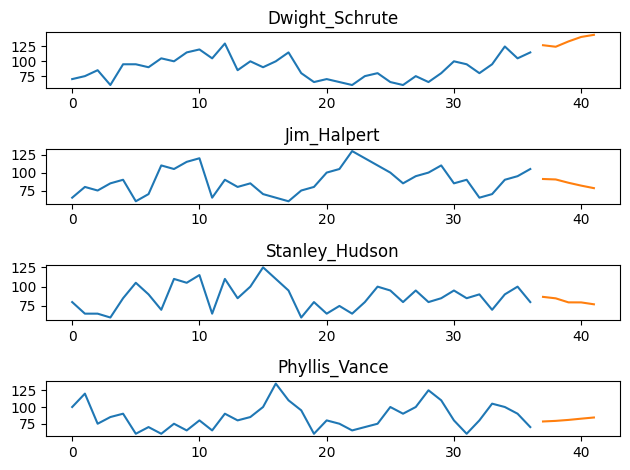

In [ ]:
plt.figure(figsize=(40, 60))
plt.subplots(4, 1)

for num, salesman in enumerate(salespeople):
    plt.subplot(4, 1, num+1)

    plt.plot(actual,df[salesman])
    plt.plot(predicted,preds[salesman])
    plt.title(salesman)

plt.tight_layout()
plt.show()

# Problem with Simple RNNs
Since we are looking only at the last n datapoints, the model seems to "forget" about the past trends. This is called the "vanishing gradient" problem.

To solve this we use LSTMs
![RNN v/s LSTM](https://drive.google.com/uc?export=view&id=16eq43QJ01qX-Q6pM6NO5SYmiyA_RFYhR)


# LSTMs
LSTMs (Long Short-Term Memory) networks were specifically designed to address the vanishing gradient problem and improve the learning of long-term dependencies.

It contains a working memory as well as a Long-term memory to "remember" distant datapoints.

![LSTM Architecture](https://drive.google.com/uc?export=view&id=1aXX2BS1dN51jDyOylW7ctvn4omcaNTEO)


# Summary
1. RNNs are used for sequential data
2. They are prone to forgetting some data when there are a large number of datapoints, this is called the vanishing gradient problem
3. LSTMs are used to solve the vanishing graddient problem by having both a working memory and a long-term memory
4. Applications include Stock prediction, Time-series forecasting, NLP, etc.


### LSTM model

In [ ]:
def get_lstm_model(n_steps,n_features):
  model = Sequential()
  model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
  model.add(LSTM(50,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss="mse")
  return model